# Load the pymoo result object saved with pickle.
ONOSControllerPlacement needs to be definded to load the result object.
So, execute the following cell first.

In [78]:
#!/usr/bin/env python
import numpy as np
import networkx as nx
import math
import pickle
from pymoo.core.problem import ElementwiseProblem

class ONOSControllerPlacement(ElementwiseProblem):
    def __init__(self, num_nodes, distance_matrix, shortest_paths, graph, **kwargs):
        super().__init__(n_var=2*num_nodes, 
                         n_obj=4, 
                         n_constr=2, 
                         xl=0, xu=1, 
                         **kwargs)
        self.num_nodes = num_nodes
        self.distance_matrix = distance_matrix
        self.shortest_paths = shortest_paths
        self.graph = graph
    
    def _evaluate(self, x, out, *args, **kwargs):
        controller_nodes = x[:self.num_nodes]   # first half is controller placement
        atomix_nodes = x[self.num_nodes:]       # second half is atomix placement


        num_controller = np.sum(controller_nodes)
        num_atomix = np.sum(atomix_nodes)

        # Obj1: Minimize number of contrtoller
        f1 = num_controller

        # Obj2: Minimize number of atomix
        f2 = num_atomix

        # Obj3: Minimize average FSP
        f3 = calculate_FST(self.num_nodes, 
                           controller_nodes, 
                           atomix_nodes, 
                           self.distance_matrix, 
                           self.shortest_paths)
        
        f4 = calculate_BC(self.num_nodes, 
                           controller_nodes, 
                           atomix_nodes, 
                           self.distance_matrix, 
                        #    self.shortest_paths,
                           self.graph)

        # Constr1: The number of controller is equal to or greater than 2
        g1 = 2 - num_controller

        # Constr2: The number of atomix is equal to or greater than 3
        g2 = 3 - num_atomix
        
        # Add the centrality metrix into optimazing objectives:
        # 1. Nearest controller for each switch
        # 2. The number of controlled switches for each controller should be <= limit_num_switches_controlled (limit_num_switches_controlled=int(math.ceil(num_nodes/num_controller)))
        # 3. return value should be the variance for all controller's betweenness centrality
        out["F"] = [f1, f2, f3, f4]
        out["G"] = [g1, g2]


def calculate_FST(num_nodes, controller_nodes, atomix_nodes, distance_matrix, shortest_paths):
    num_controller = np.sum(controller_nodes)
    num_atomix = np.sum(atomix_nodes)
    controller_list = np.nonzero(controller_nodes)[0].tolist()
    atomix_list = np.nonzero(atomix_nodes)[0].tolist()

    if(num_controller == 0 or num_atomix ==0):
        return math.inf

    # find the nearest controller for each switch
    controller_of = []
    for s in range(num_nodes):
        delay = math.inf
        nearest_controller = None
        for c in controller_list:
            if distance_matrix[s][c] < delay:
                delay = distance_matrix[s][c]
                nearest_controller = c
        controller_of.append(nearest_controller)    

    # calculate average delay to atomix nodes from each controller
    average_atomix_delay_from = {}
    for c in controller_list:
        delay = []
        for a in atomix_list:
            delay.append(distance_matrix[c][a])
        average_atomix_delay_from[c] = np.mean(delay)

    # find the nearest atomix for each atomix and calculate average delay
    atomix_atomix_delays = []
    for a1 in atomix_list:
        delay = math.inf
        for a2 in atomix_list:
            if(a1 == a2):
                continue
            if distance_matrix[a1][a2] < delay:
                delay = distance_matrix[a1][a2]
        atomix_atomix_delays.append(delay)
    average_atomix_atomix_delay = np.mean(atomix_atomix_delays)
    FTSs = []
    for source in range(num_nodes):
        for distination in range(num_nodes):
            if(source == distination):
                continue
            delay = 0
            is_controlled_by_single_controller = True
            counted_controllers = []
            for s in shortest_paths[source][distination]:
                # switch-controller delay
                delay += distance_matrix[s][controller_of[s]] * 4

                # controller-atomix delay
                if(s == source):
                    delay += average_atomix_delay_from[controller_of[s]] * 2
                elif(s != distination):
                    if(controller_of[s] != controller_of[source]):
                        is_controlled_by_single_controller = False
                        if(not controller_of[s] in counted_controllers):
                            counted_controllers.append(controller_of[s])
                            delay += average_atomix_delay_from[controller_of[s]]
                else:
                    if(controller_of[s] == controller_of[source]):
                        if(not is_controlled_by_single_controller):
                            delay += average_atomix_delay_from[controller_of[s]]
                    else:
                        delay += average_atomix_delay_from[controller_of[s]] * 2
            
            # atomix-atomix delay
            delay +=  average_atomix_atomix_delay * 2
            FTSs.append(delay)

    return np.mean(FTSs)



def calculate_BC(num_nodes, controller_nodes, atomix_nodes, distance_matrix, graph):
    G = nx.Graph()
    for node1 in range(len(graph)):
        G.add_node(str(node1))
        for node2, delay in graph[node1].items():
            G.add_edge(str(node1), str(node2), weight=delay)
    
    # The list of betweenness centrality for all switches
    nodes_bc=nx.current_flow_betweenness_centrality(G, normalized=True, weight=None, dtype='float', solver='full')
    num_controller = np.sum(controller_nodes)
    num_atomix = np.sum(atomix_nodes)
    controller_list = np.nonzero(controller_nodes)[0].tolist()

    if(num_controller == 0 or num_atomix ==0):
        return math.inf

    # find the nearest controller for each switch
    controller_of = []
    limit_num_switches_controlled=int(math.ceil(num_nodes/num_controller)) # balance the number of switches controllers can control 
    switches_bc_of_controller_ = dict.fromkeys((range(num_nodes)),0) # list of sum of betweenness centrality of switches for each controller
    for s in range(num_nodes):
        delay = math.inf
        nearest_controller = None
        controlled_switches=[]
        for c in controller_list:
            # Conditions: nearest controller (with the lowest delay) && the number of switches for each controller < limit_num_switches_controlled
            if distance_matrix[s][c] < delay and controller_of.count(c) < limit_num_switches_controlled:
                delay = distance_matrix[s][c]
                nearest_controller = c
                controlled_switches.append(s)
        switches_bc_of_controller_[nearest_controller] += nodes_bc[str(s)]
        controller_of.append(nearest_controller)
    
    # Simplify switches_bc_of_controller_ (only need value for calculating variance)
    bc_array = []
    for i in switches_bc_of_controller_.values():
        bc_array.append(i)

    # return variance value can show the degree of balance within all controllers
    return np.var(bc_array)

## Load result object
Place a pymoo result object file saved with pickle and execute the following cell.
Replace 'res_Cogent.pkl' with your result file saved with pickle.

In [79]:
# with open('res_bc_Cogent_nsga2.pkl','rb') as f:
    # res = pickle.load(f)
# with open('res_bc_UsCarrier_nsga2.pkl','rb') as f:
    # res = pickle.load(f)
# with open('res_bc_HiberniaGlobal_nsga2.pkl','rb') as f:
    # res = pickle.load(f)
# with open('res_bc_Colt_nsga2.pkl','rb') as f:
    # res = pickle.load(f)
# with open('res_bc_Funet_nsga2.pkl','rb') as f:
    # res = pickle.load(f)
# with open('res_bc_Abvt_nsga2.pkl','rb') as f:
    # res = pickle.load(f)
# with open('res_bc_Intellifiber_nsga2.pkl','rb') as f:
    # res = pickle.load(f)
# with open('res_bc_TataNld_nsga2.pkl','rb') as f:
    # res = pickle.load(f)
# with open('res_bc_Kdl_nsga2.pkl','rb') as f:
#     res = pickle.load(f)
# with open('res_bc_Internode_nsga2.pkl','rb') as f:
    # res = pickle.load(f)
# with open('res_bc_Missouri_nsga2.pkl','rb') as f:
    # res = pickle.load(f)
# with open('res_bc_Ion_nsga2.pkl','rb') as f:
    # res = pickle.load(f)
with open('res_bc_Palmetto_nsga2.pkl','rb') as f:
    res = pickle.load(f)

## Show all optimal solutions

In [80]:
F = res.F
print(F[np.argsort(F[:, 0])])

[[2.00000000e+00 3.00000000e+00 1.39917017e+02 4.44467384e-01]
 [2.00000000e+00 3.00000000e+00 2.48284571e+02 4.44466485e-01]
 [3.00000000e+00 3.00000000e+00 1.31216672e+02 2.90710558e-01]
 [3.00000000e+00 3.00000000e+00 1.43784502e+02 2.89530034e-01]
 [3.00000000e+00 3.00000000e+00 2.26278697e+02 2.89528590e-01]
 [3.00000000e+00 3.00000000e+00 2.63636030e+02 2.89513724e-01]
 [3.00000000e+00 3.00000000e+00 1.37098529e+02 2.90220760e-01]
 [3.00000000e+00 3.00000000e+00 1.47700878e+02 2.89530034e-01]
 [3.00000000e+00 3.00000000e+00 1.20850689e+02 2.90870397e-01]
 [4.00000000e+00 3.00000000e+00 1.05835872e+02 2.23212820e-01]
 [4.00000000e+00 3.00000000e+00 1.10720533e+02 2.16543127e-01]
 [4.00000000e+00 3.00000000e+00 1.12537428e+02 2.12777643e-01]
 [4.00000000e+00 3.00000000e+00 1.25120903e+02 2.12187702e-01]
 [4.00000000e+00 3.00000000e+00 1.32958914e+02 2.12056126e-01]
 [5.00000000e+00 3.00000000e+00 1.04393307e+02 1.68099978e-01]
 [5.00000000e+00 3.00000000e+00 1.17206580e+02 1.655797

## Find the best case and the worst Case in the result set.

Ideal point:  [2.00000000e+00 3.00000000e+00 6.60933187e+01 8.42905792e-03]
Nadir point:  [ 43.           7.         263.63602958   0.44446738]


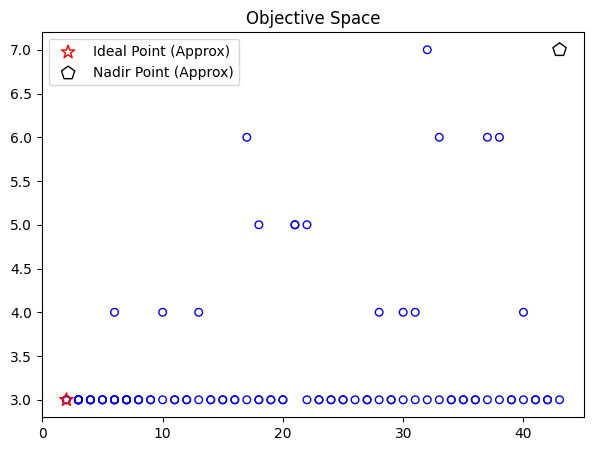

In [81]:
import matplotlib.pyplot as plt

approx_ideal = F.min(axis=0)
approx_nadir = F.max(axis=0)

# nadir_point = np.max(F, axis=0)

# print("Nadir Point:", nadir_point)

print("Ideal point: ", approx_ideal)
print("Nadir point: ", approx_nadir)

with open('ips_of_all_9_algos.txt', 'a', encoding='utf-8') as f:
    f.write('NSGA2: ' + str(approx_ideal))
    f.write('\n')

with open('nps_of_all_9_algos.txt', 'a', encoding='utf-8') as f1:
    f1.write('NSGA2: ' + str(approx_nadir))
    f1.write('\n')

plt.figure(figsize=(7, 5))
plt.scatter(F[:, 0], F[:, 1], s=30, facecolors='none', edgecolors='blue')
plt.scatter(approx_ideal[0], approx_ideal[1], facecolors='none', edgecolors='red', marker="*", s=100, label="Ideal Point (Approx)")
plt.scatter(approx_nadir[0], approx_nadir[1], facecolors='none', edgecolors='black', marker="p", s=100, label="Nadir Point (Approx)")
plt.title("Objective Space")
plt.legend()
plt.show()

## Find the worst points from all the worst points got from 9 Algorithms.

In [82]:
OP_9 = np.array([
    [7.80000000e+01, 3.00000000e+00, 5.50774458e+02, 3.13698896e-02],
    [8.90000000e+01, 1.20000000e+01, 8.50780094e+02, 4.87181473e-02],
    [1.02000000e+02, 1.10000000e+01, 9.44129315e+02, 4.99045873e-02],
    [1.48000000e+02, 2.90000000e+01, 1.34983472e+03, 1.41678773e-01],
    [1.81000000e+02, 6.20000000e+01, 2.30131720e+03, 5.57996615e-01],
    [1.32000000e+02, 1.00000000e+01, 9.35110737e+02, 8.37155719e-02],
    [3.30000000e+01, 5.00000000e+00, 7.51246636e+02, 6.64373708e-02],
    [9.90000000e+01, 9.00000000e+00, 9.69715534e+02, 8.15163675e-02],
    [6.10000000e+01, 4.60000000e+01, 3.92281875e+03, 1.11500312e+00],
    [7.70000000e+01, 1.10000000e+01, 7.08502336e+02, 1.31996837e-01],
    [6.90000000e+01, 5.00000000e+00, 4.70013336e+02, 8.11112088e-02],
    [1.51000000e+02, 6.10000000e+01, 1.29188018e+03, 8.65002149e-01],
    [8.90000000e+01, 1.10000000e+01, 5.25648070e+02, 1.30250233e-01],
    [3.30000000e+01, 3.00000000e+00, 3.13578243e+02, 1.00537307e-01],
    [1.08000000e+02, 2.10000000e+01, 1.12880004e+03, 8.32832566e-01],
    [1.18000000e+02, 7.00000000e+00, 6.57427294e+02, 4.22859656e-01],
    [9.70000000e+01, 9.00000000e+00, 6.23517292e+02, 1.93781440e-01],
    [4.60000000e+01, 3.20000000e+01, 1.87818171e+03, 1.67633822e+00],
    [ 54.,          13.,         472.65627098,   0.50854198],
    [5.40000000e+01, 4.00000000e+00, 8.01363807e+02, 5.08541981e-01],
    [4.50000000e+01, 8.00000000e+00, 1.20152765e+03, 5.08541981e-01],
    [3.70000000e+01, 3.00000000e+00, 2.79933209e+02, 1.24929578e-01],
    [5.30000000e+01, 1.90000000e+01, 5.14592880e+02, 5.08541981e-01],
    [3.40000000e+01, 2.30000000e+01, 1.63478971e+03, 1.03617990e+00],
    [2.50000000e+01, 4.00000000e+00, 3.54016795e+02, 8.66655880e-02],
    [ 37.,           9.,         478.18389939,   0.50854198],
    [ 40.,           8.,         482.04222046,   0.50854198],
    [7.30000000e+01, 7.00000000e+00, 3.93282918e+02, 1.20804554e-01],
    [1.00000000e+02, 1.20000000e+01, 1.28629267e+03, 4.23965609e-01],
    [8.60000000e+01, 7.00000000e+00, 1.21102115e+03, 4.33539733e-01],
    [6.20000000e+01, 3.00000000e+00, 2.44631858e+02, 7.59455443e-02],
    [7.00000000e+01, 1.10000000e+01, 6.48489192e+02, 1.34490175e-01],
    [1.12000000e+02, 4.40000000e+01, 1.00597810e+03, 4.37362608e-01],
    [5.80000000e+01, 2.90000000e+01, 1.70468701e+03, 8.48719879e-01],
    [5.70000000e+01, 6.00000000e+00, 6.59867734e+02, 4.22174170e-01],
    [3.10000000e+01, 4.00000000e+00, 3.79596414e+02, 8.19166959e-02],
    [ 25.,           5.,         259.38179819,   0.55897608],
    [ 25.,           5.,         340.64244974,   0.55897608],
    [ 25.,           8.,         331.12924814,   0.55897608],
    [ 21.,           5.,         261.35488016,   0.55897608],
    [ 18.,           4.,         142.89748851,   0.16236902],
    [ 22.,           4.,         188.33058439,   0.19724014],
    [ 24.,           5.,         244.92072858,   0.55897608],
    [ 22.,          15.,         842.5578025,    1.14759191],
    [ 23.,           5.,         283.65573261,   0.55103338],
    [2.30000000e+01, 4.00000000e+00, 4.50692499e+02, 3.46371762e-01],
    [ 23.,           4.,         327.9191185,    0.34637176],
    [2.20000000e+01, 5.00000000e+00, 5.57443347e+02, 3.46371762e-01],
    [2.20000000e+01, 4.00000000e+00, 3.86367315e+02, 3.36595313e-01],
    [2.00000000e+01, 3.00000000e+00, 2.02482055e+02, 1.53317824e-01],
    [1.90000000e+01, 4.00000000e+00, 2.08751327e+02, 1.56143978e-01],
    [ 20.,          20.,         609.91260381,   0.70517868],
    [ 23.,           5.,         317.97518727,   0.33788525],
    [2.10000000e+01, 4.00000000e+00, 5.04615386e+02, 3.36595313e-01],
    [7.10000000e+01, 3.90000000e+01, 6.32752812e+02, 4.65920322e-01],
    [ 65.,          15.,         458.0855871,    0.46504195],
    [ 48.,           8.,         310.39278583,   0.33171141],
    [ 64.,           7.,         356.03613084,   0.46498472],
    [3.90000000e+01, 3.00000000e+00, 2.32588615e+02, 9.56635066e-02],
    [ 44.,           9.,         461.04296374,   0.46504195],
    [2.30000000e+01, 3.00000000e+00, 1.87453223e+02, 7.99174383e-02],
    [ 42.,           5.,         334.73819937,   0.46504195],
    [ 41.,          30.,         909.7727009,    0.94306739],
    [8.50000000e+01, 9.00000000e+00, 6.93915828e+02, 7.24844209e-02],
    [1.15000000e+02, 4.10000000e+01, 1.76036553e+03, 6.50419426e-01],
    [4.50000000e+01, 4.00000000e+00, 6.14344399e+02, 1.25450496e-01],
    [1.35000000e+02, 5.60000000e+01, 2.10923151e+03, 6.49034499e-01],
    [1.09000000e+02, 1.30000000e+01, 9.25265351e+02, 2.17404531e-01],
    [8.50000000e+01, 1.40000000e+01, 6.54448844e+02, 6.30783289e-02],
    [3.10000000e+01, 4.00000000e+00, 4.31933934e+02, 5.67771415e-02],
    [8.40000000e+01, 1.20000000e+01, 7.51017475e+02, 1.41217615e-01],
    [4.50000000e+01, 4.30000000e+01, 1.99375186e+03, 6.55775098e-01],
    [5.20000000e+01, 5.00000000e+00, 3.54274980e+02, 1.17181091e-01],
    [5.20000000e+01, 5.00000000e+00, 2.18816476e+02, 1.17181091e-01],
    [4.50000000e+01, 4.00000000e+00, 3.05958730e+02, 1.17181091e-01],
    [5.30000000e+01, 5.00000000e+00, 2.68723482e+02, 1.17181091e-01],
    [4.30000000e+01, 3.00000000e+00, 1.16235821e+02, 6.73569087e-02],
    [1.20000000e+01, 3.00000000e+00, 2.11593422e+02, 1.17181091e-01],
    [4.30000000e+01, 4.00000000e+00, 2.61438979e+02, 7.73512587e-02],
    [4.70000000e+01, 5.00000000e+00, 2.34769377e+02, 1.14725276e-01],
    [4.90000000e+01, 3.40000000e+01, 4.55486455e+02, 2.30965757e-01],
    [ 63.,          24.,         160.71147464,   0.56236426],
    [ 46.,           8.,         137.80143449,   0.37588988],
    [ 61.,          12.,         201.72740617,   0.56236426],
    [ 48.,           3.,         159.16155796,   0.27253655],
    [ 61.,           7.,         147.27953879,   0.56239215],
    [ 13.,           4.,         122.71808754,   0.56236426],
    [ 49.,           9.,         211.68085347,   0.56236426],
    [ 45.,          35.,         408.02420571,   1.1420305 ],
    [ 48.,           9.,         161.25589646,   0.56239215],
    [6.50000000e+01, 1.10000000e+01, 6.93065095e+02, 2.38887195e-01],
    [4.10000000e+01, 1.20000000e+01, 5.48671572e+02, 1.66096898e-01],
    [7.40000000e+01, 1.30000000e+01, 5.45156953e+02, 1.62611565e-01],
    [8.00000000e+01, 1.50000000e+01, 5.28989126e+02, 2.78401195e-01],
    [2.40000000e+01, 5.00000000e+00, 3.53490304e+02, 9.56541172e-02],
    [4.10000000e+01, 2.10000000e+01, 3.06519423e+03, 1.70537209e+00],
    [1.06000000e+02, 5.30000000e+01, 1.41982421e+03, 8.46232686e-01],
    [9.00000000e+01, 1.30000000e+01, 1.23407492e+03, 8.46149211e-01],
    [8.80000000e+01, 2.30000000e+01, 1.42708964e+03, 8.46232686e-01],
    [ 43.,           7.,         263.63602958,   0.44446738],
    [ 38.,           6.,         161.95442122,   0.29038992],
    [ 43.,           9.,         221.42058684,   0.44621725],
    [ 42.,           5.,         159.36303324,   0.44446738],
    [ 38.,           3.,         142.20786878,   0.28952268],
    [ 20.,           4.,         161.88657071,   0.44699751],
    [ 35.,           6.,         154.79071049,   0.29038992],
    [ 28.,          25.,         446.98978649,   0.9096057 ],
    [ 34.,           6.,         144.35625026,   0.44446738],
])

# print(OP_9)
# print(len(OP_9))
print(OP_9[np.argsort(OP_9[:, 0])])
nadir_9 = np.max(OP_9, axis=0)
print("Nadir Point:", nadir_9)

# P1 = np.array([
#     [2, 3, 8, 7],
#     [2, 3, 8, 1],
#     [2, 3, 8, 2],
#     [2, 4, 8, 3],
#     [2, 5, 8, 4],
#     [2, 3, 8, 5],
#     [2, 3, 8, 6],
#     [2, 3, 8, 7],
# ])

# nadir_ = np.max(P1, axis=0)
# print("Nadir Point:", nadir_)

[[1.20000000e+01 3.00000000e+00 2.11593422e+02 1.17181091e-01]
 [1.30000000e+01 4.00000000e+00 1.22718088e+02 5.62364260e-01]
 [1.80000000e+01 4.00000000e+00 1.42897489e+02 1.62369020e-01]
 [1.90000000e+01 4.00000000e+00 2.08751327e+02 1.56143978e-01]
 [2.00000000e+01 3.00000000e+00 2.02482055e+02 1.53317824e-01]
 [2.00000000e+01 2.00000000e+01 6.09912604e+02 7.05178680e-01]
 [2.00000000e+01 4.00000000e+00 1.61886571e+02 4.46997510e-01]
 [2.10000000e+01 4.00000000e+00 5.04615386e+02 3.36595313e-01]
 [2.10000000e+01 5.00000000e+00 2.61354880e+02 5.58976080e-01]
 [2.20000000e+01 1.50000000e+01 8.42557802e+02 1.14759191e+00]
 [2.20000000e+01 4.00000000e+00 3.86367315e+02 3.36595313e-01]
 [2.20000000e+01 5.00000000e+00 5.57443347e+02 3.46371762e-01]
 [2.20000000e+01 4.00000000e+00 1.88330584e+02 1.97240140e-01]
 [2.30000000e+01 5.00000000e+00 2.83655733e+02 5.51033380e-01]
 [2.30000000e+01 5.00000000e+00 3.17975187e+02 3.37885250e-01]
 [2.30000000e+01 3.00000000e+00 1.87453223e+02 7.991743

## Find the worst points from all the worst points got from 4 Algorithms.

In [83]:
OP_4 = np.array([
    [1.60000000e+02, 7.70000000e+01, 2.42579968e+03, 5.54782904e-01],
    [5.00000000e+01, 2.00000000e+00, 4.78439084e+02, 3.15581763e-02],
    [2.01975573e+00, 3.42037326e+00, 9.34060751e+02, 4.73550988e-03],
    [1.59000000e+02, 7.70000000e+01, 2.24462070e+03, 3.68577721e-01],
    [1.26000000e+02, 6.50000000e+01, 1.06713794e+03, 8.33050791e-01],
    [2.57107614e+00, 3.00219154e+00, 5.66012939e+02, 7.97869833e-03],
    [133.,  77.,  np.inf,  np.inf],
    [3.60000000e+01, 6.00000000e+00, 2.91551921e+02, 7.82516851e-02],
    [2.27888860e+00, 3.42537038e+00, 3.57333507e+02, 1.21116142e-02],
    [45., 27., np.inf, np.inf],
    [52., 15., np.inf, np.inf],
    [2.60000000e+01, 2.00000000e+00, 2.26322141e+02, 8.76636643e-02],
    [113.,  45.,  np.inf,  np.inf],
    [116.,  53.,  np.inf,  np.inf],
    [3.10000000e+01, 2.00000000e+00, 2.19109658e+02, 4.82369287e-02],
    [3.11350535e+00, 3.05254527e+00, 4.57065649e+02, 9.85040400e-03],
    [6.76892293e+00, 3.72459031e+00, 1.61900909e+02, 1.27267197e-02],
    [24.,  7., np.inf, np.inf],
    [24.,  8., np.inf, np.inf],
    [18.,           5.,         128.69190002,   0.13356703],
    [3.66872160e+00, 3.52644924e+00, 1.74811615e+02, 1.31232371e-02],
    [23.,  6., np.inf, np.inf],
    [23.,  6., np.inf, np.inf],
    [1.90000000e+01, 2.00000000e+00, 1.47465820e+02, 6.49921347e-02],
    [2.61443983e+00, 3.17744227e+00, 2.76849364e+02, 9.69692326e-03],
    [64., 34., np.inf, np.inf],
    [56.,         47.,                 np.inf,  0.94306739],
    [2.20000000e+01, 5.00000000e+00, 1.82303075e+02, 7.90147417e-02],
    [128.,          59.,                  np.inf,   1.30714633],
    [132.,  69.,  np.inf,  np.inf],
    [2.82905256e+00, 3.06653366e+00, 6.98041734e+02, 3.96072190e-03],
    [3.80000000e+01, 8.00000000e+00, 4.03967709e+02, 4.21894987e-02],
    [39.,  5., np.inf, np.inf],
    [2.13375106e+00, 3.25816043e+00, 1.49499822e+02, 2.16407958e-02],
    [46.,  6., np.inf, np.inf],
    [2.60000000e+01, 2.00000000e+00, 9.39898447e+01, 3.51625435e-02],
    [2.22571509e+00, 3.56408554e+00, 1.00155816e+02, 8.81261896e-03],
    [60., 39., np.inf, np.inf],
    [60., 32., np.inf, np.inf],
    [21.,          5.,         72.42408877,  0.09903623],
    [110.,  67.,  np.inf,  np.inf],
    [109.,  58.,  np.inf,  np.inf],
    [3.10000000e+01, 6.00000000e+00, 2.76526914e+02, 8.97338895e-02],
    [6.43809676e+01, 5.88667938e+01, 4.92520444e+02, 9.15396363e-03],
    [2.38591191e+00, 3.13716181e+00, 1.05039641e+02, 8.42905792e-03],
    [42., 14., np.inf, np.inf],
    [42., 16., np.inf, np.inf],
    [19.,          4.,         85.12296266,  0.12391128],
])

print(OP_4[np.argsort(OP_4[:, 0])])
nadir_4 = np.max(OP_4, axis=0)
print("Nadir Point:", nadir_4)


[[2.01975573e+00 3.42037326e+00 9.34060751e+02 4.73550988e-03]
 [2.13375106e+00 3.25816043e+00 1.49499822e+02 2.16407958e-02]
 [2.22571509e+00 3.56408554e+00 1.00155816e+02 8.81261896e-03]
 [2.27888860e+00 3.42537038e+00 3.57333507e+02 1.21116142e-02]
 [2.38591191e+00 3.13716181e+00 1.05039641e+02 8.42905792e-03]
 [2.57107614e+00 3.00219154e+00 5.66012939e+02 7.97869833e-03]
 [2.61443983e+00 3.17744227e+00 2.76849364e+02 9.69692326e-03]
 [2.82905256e+00 3.06653366e+00 6.98041734e+02 3.96072190e-03]
 [3.11350535e+00 3.05254527e+00 4.57065649e+02 9.85040400e-03]
 [3.66872160e+00 3.52644924e+00 1.74811615e+02 1.31232371e-02]
 [6.76892293e+00 3.72459031e+00 1.61900909e+02 1.27267197e-02]
 [1.80000000e+01 5.00000000e+00 1.28691900e+02 1.33567030e-01]
 [1.90000000e+01 4.00000000e+00 8.51229627e+01 1.23911280e-01]
 [1.90000000e+01 2.00000000e+00 1.47465820e+02 6.49921347e-02]
 [2.10000000e+01 5.00000000e+00 7.24240888e+01 9.90362300e-02]
 [2.20000000e+01 5.00000000e+00 1.82303075e+02 7.901474

## Find the worst points from all the worst points got from all Algorithms.

In [84]:
OP_all = np.array([
    [7.80000000e+01, 3.00000000e+00, 5.50774458e+02, 3.13698896e-02],
    [8.90000000e+01, 1.20000000e+01, 8.50780094e+02, 4.87181473e-02],
    [1.02000000e+02, 1.10000000e+01, 9.44129315e+02, 4.99045873e-02],
    [1.48000000e+02, 2.90000000e+01, 1.34983472e+03, 1.41678773e-01],
    [1.81000000e+02, 6.20000000e+01, 2.30131720e+03, 5.57996615e-01],
    [1.32000000e+02, 1.00000000e+01, 9.35110737e+02, 8.37155719e-02],
    [3.30000000e+01, 5.00000000e+00, 7.51246636e+02, 6.64373708e-02],
    [9.90000000e+01, 9.00000000e+00, 9.69715534e+02, 8.15163675e-02],
    [6.10000000e+01, 4.60000000e+01, 3.92281875e+03, 1.11500312e+00],
    [7.70000000e+01, 1.10000000e+01, 7.08502336e+02, 1.31996837e-01],
    [6.90000000e+01, 5.00000000e+00, 4.70013336e+02, 8.11112088e-02],
    [1.51000000e+02, 6.10000000e+01, 1.29188018e+03, 8.65002149e-01],
    [8.90000000e+01, 1.10000000e+01, 5.25648070e+02, 1.30250233e-01],
    [3.30000000e+01, 3.00000000e+00, 3.13578243e+02, 1.00537307e-01],
    [1.08000000e+02, 2.10000000e+01, 1.12880004e+03, 8.32832566e-01],
    [1.18000000e+02, 7.00000000e+00, 6.57427294e+02, 4.22859656e-01],
    [9.70000000e+01, 9.00000000e+00, 6.23517292e+02, 1.93781440e-01],
    [4.60000000e+01, 3.20000000e+01, 1.87818171e+03, 1.67633822e+00],
    [ 54.,          13.,         472.65627098,   0.50854198],
    [5.40000000e+01, 4.00000000e+00, 8.01363807e+02, 5.08541981e-01],
    [4.50000000e+01, 8.00000000e+00, 1.20152765e+03, 5.08541981e-01],
    [3.70000000e+01, 3.00000000e+00, 2.79933209e+02, 1.24929578e-01],
    [5.30000000e+01, 1.90000000e+01, 5.14592880e+02, 5.08541981e-01],
    [3.40000000e+01, 2.30000000e+01, 1.63478971e+03, 1.03617990e+00],
    [2.50000000e+01, 4.00000000e+00, 3.54016795e+02, 8.66655880e-02],
    [ 37.,           9.,         478.18389939,   0.50854198],
    [ 40.,           8.,         482.04222046,   0.50854198],
    [7.30000000e+01, 7.00000000e+00, 3.93282918e+02, 1.20804554e-01],
    [1.00000000e+02, 1.20000000e+01, 1.28629267e+03, 4.23965609e-01],
    [8.60000000e+01, 7.00000000e+00, 1.21102115e+03, 4.33539733e-01],
    [6.20000000e+01, 3.00000000e+00, 2.44631858e+02, 7.59455443e-02],
    [7.00000000e+01, 1.10000000e+01, 6.48489192e+02, 1.34490175e-01],
    [1.12000000e+02, 4.40000000e+01, 1.00597810e+03, 4.37362608e-01],
    [5.80000000e+01, 2.90000000e+01, 1.70468701e+03, 8.48719879e-01],
    [5.70000000e+01, 6.00000000e+00, 6.59867734e+02, 4.22174170e-01],
    [3.10000000e+01, 4.00000000e+00, 3.79596414e+02, 8.19166959e-02],
    [ 25.,           5.,         259.38179819,   0.55897608],
    [ 25.,           5.,         340.64244974,   0.55897608],
    [ 25.,           8.,         331.12924814,   0.55897608],
    [ 21.,           5.,         261.35488016,   0.55897608],
    [ 18.,           4.,         142.89748851,   0.16236902],
    [ 22.,           4.,         188.33058439,   0.19724014],
    [ 24.,           5.,         244.92072858,   0.55897608],
    [ 22.,          15.,         842.5578025,    1.14759191],
    [ 23.,           5.,         283.65573261,   0.55103338],
    [2.30000000e+01, 4.00000000e+00, 4.50692499e+02, 3.46371762e-01],
    [ 23.,           4.,         327.9191185,    0.34637176],
    [2.20000000e+01, 5.00000000e+00, 5.57443347e+02, 3.46371762e-01],
    [2.20000000e+01, 4.00000000e+00, 3.86367315e+02, 3.36595313e-01],
    [2.00000000e+01, 3.00000000e+00, 2.02482055e+02, 1.53317824e-01],
    [1.90000000e+01, 4.00000000e+00, 2.08751327e+02, 1.56143978e-01],
    [ 20.,          20.,         609.91260381,   0.70517868],
    [ 23.,           5.,         317.97518727,   0.33788525],
    [2.10000000e+01, 4.00000000e+00, 5.04615386e+02, 3.36595313e-01],
    [7.10000000e+01, 3.90000000e+01, 6.32752812e+02, 4.65920322e-01],
    [ 65.,          15.,         458.0855871,    0.46504195],
    [ 48.,           8.,         310.39278583,   0.33171141],
    [ 64.,           7.,         356.03613084,   0.46498472],
    [3.90000000e+01, 3.00000000e+00, 2.32588615e+02, 9.56635066e-02],
    [ 44.,           9.,         461.04296374,   0.46504195],
    [2.30000000e+01, 3.00000000e+00, 1.87453223e+02, 7.99174383e-02],
    [ 42.,           5.,         334.73819937,   0.46504195],
    [ 41.,          30.,         909.7727009,    0.94306739],
    [8.50000000e+01, 9.00000000e+00, 6.93915828e+02, 7.24844209e-02],
    [1.15000000e+02, 4.10000000e+01, 1.76036553e+03, 6.50419426e-01],
    [4.50000000e+01, 4.00000000e+00, 6.14344399e+02, 1.25450496e-01],
    [1.35000000e+02, 5.60000000e+01, 2.10923151e+03, 6.49034499e-01],
    [1.09000000e+02, 1.30000000e+01, 9.25265351e+02, 2.17404531e-01],
    [8.50000000e+01, 1.40000000e+01, 6.54448844e+02, 6.30783289e-02],
    [3.10000000e+01, 4.00000000e+00, 4.31933934e+02, 5.67771415e-02],
    [8.40000000e+01, 1.20000000e+01, 7.51017475e+02, 1.41217615e-01],
    [4.50000000e+01, 4.30000000e+01, 1.99375186e+03, 6.55775098e-01],
    [5.20000000e+01, 5.00000000e+00, 3.54274980e+02, 1.17181091e-01],
    [5.20000000e+01, 5.00000000e+00, 2.18816476e+02, 1.17181091e-01],
    [4.50000000e+01, 4.00000000e+00, 3.05958730e+02, 1.17181091e-01],
    [5.30000000e+01, 5.00000000e+00, 2.68723482e+02, 1.17181091e-01],
    [4.30000000e+01, 3.00000000e+00, 1.16235821e+02, 6.73569087e-02],
    [1.20000000e+01, 3.00000000e+00, 2.11593422e+02, 1.17181091e-01],
    [4.30000000e+01, 4.00000000e+00, 2.61438979e+02, 7.73512587e-02],
    [4.70000000e+01, 5.00000000e+00, 2.34769377e+02, 1.14725276e-01],
    [4.90000000e+01, 3.40000000e+01, 4.55486455e+02, 2.30965757e-01],
    [ 63.,          24.,         160.71147464,   0.56236426],
    [ 46.,           8.,         137.80143449,   0.37588988],
    [ 61.,          12.,         201.72740617,   0.56236426],
    [ 48.,           3.,         159.16155796,   0.27253655],
    [ 61.,           7.,         147.27953879,   0.56239215],
    [ 13.,           4.,         122.71808754,   0.56236426],
    [ 49.,           9.,         211.68085347,   0.56236426],
    [ 45.,          35.,         408.02420571,   1.1420305 ],
    [ 48.,           9.,         161.25589646,   0.56239215],
    [6.50000000e+01, 1.10000000e+01, 6.93065095e+02, 2.38887195e-01],
    [4.10000000e+01, 1.20000000e+01, 5.48671572e+02, 1.66096898e-01],
    [7.40000000e+01, 1.30000000e+01, 5.45156953e+02, 1.62611565e-01],
    [8.00000000e+01, 1.50000000e+01, 5.28989126e+02, 2.78401195e-01],
    [2.40000000e+01, 5.00000000e+00, 3.53490304e+02, 9.56541172e-02],
    [4.10000000e+01, 2.10000000e+01, 3.06519423e+03, 1.70537209e+00],
    [1.06000000e+02, 5.30000000e+01, 1.41982421e+03, 8.46232686e-01],
    [9.00000000e+01, 1.30000000e+01, 1.23407492e+03, 8.46149211e-01],
    [8.80000000e+01, 2.30000000e+01, 1.42708964e+03, 8.46232686e-01],
    [ 43.,           7.,         263.63602958,   0.44446738],
    [ 38.,           6.,         161.95442122,   0.29038992],
    [ 43.,           9.,         221.42058684,   0.44621725],
    [ 42.,           5.,         159.36303324,   0.44446738],
    [ 38.,           3.,         142.20786878,   0.28952268],
    [ 20.,           4.,         161.88657071,   0.44699751],
    [ 35.,           6.,         154.79071049,   0.29038992],
    [ 28.,          25.,         446.98978649,   0.9096057 ],
    [ 34.,           6.,         144.35625026,   0.44446738],
        [1.60000000e+02, 7.70000000e+01, 2.42579968e+03, 5.54782904e-01],
    [5.00000000e+01, 2.00000000e+00, 4.78439084e+02, 3.15581763e-02],
    [2.01975573e+00, 3.42037326e+00, 9.34060751e+02, 4.73550988e-03],
    [1.59000000e+02, 7.70000000e+01, 2.24462070e+03, 3.68577721e-01],
    [1.26000000e+02, 6.50000000e+01, 1.06713794e+03, 8.33050791e-01],
    [2.57107614e+00, 3.00219154e+00, 5.66012939e+02, 7.97869833e-03],
    [133.,  77.,  np.inf,  np.inf],
    [3.60000000e+01, 6.00000000e+00, 2.91551921e+02, 7.82516851e-02],
    [2.27888860e+00, 3.42537038e+00, 3.57333507e+02, 1.21116142e-02],
    [45., 27., np.inf, np.inf],
    [52., 15., np.inf, np.inf],
    [2.60000000e+01, 2.00000000e+00, 2.26322141e+02, 8.76636643e-02],
    [113.,  45.,  np.inf,  np.inf],
    [116.,  53.,  np.inf,  np.inf],
    [3.10000000e+01, 2.00000000e+00, 2.19109658e+02, 4.82369287e-02],
    [3.11350535e+00, 3.05254527e+00, 4.57065649e+02, 9.85040400e-03],
    [6.76892293e+00, 3.72459031e+00, 1.61900909e+02, 1.27267197e-02],
    [24.,  7., np.inf, np.inf],
    [24.,  8., np.inf, np.inf],
    [18.,           5.,         128.69190002,   0.13356703],
    [3.66872160e+00, 3.52644924e+00, 1.74811615e+02, 1.31232371e-02],
    [23.,  6., np.inf, np.inf],
    [23.,  6., np.inf, np.inf],
    [1.90000000e+01, 2.00000000e+00, 1.47465820e+02, 6.49921347e-02],
    [2.61443983e+00, 3.17744227e+00, 2.76849364e+02, 9.69692326e-03],
    [64., 34., np.inf, np.inf],
    [56.,         47.,                 np.inf,  0.94306739],
    [2.20000000e+01, 5.00000000e+00, 1.82303075e+02, 7.90147417e-02],
    [128.,          59.,                  np.inf,   1.30714633],
    [132.,  69.,  np.inf,  np.inf],
    [2.82905256e+00, 3.06653366e+00, 6.98041734e+02, 3.96072190e-03],
    [3.80000000e+01, 8.00000000e+00, 4.03967709e+02, 4.21894987e-02],
    [39.,  5., np.inf, np.inf],
    [2.13375106e+00, 3.25816043e+00, 1.49499822e+02, 2.16407958e-02],
    [46.,  6., np.inf, np.inf],
    [2.60000000e+01, 2.00000000e+00, 9.39898447e+01, 3.51625435e-02],
    [2.22571509e+00, 3.56408554e+00, 1.00155816e+02, 8.81261896e-03],
    [60., 39., np.inf, np.inf],
    [60., 32., np.inf, np.inf],
    [21.,          5.,         72.42408877,  0.09903623],
    [110.,  67.,  np.inf,  np.inf],
    [109.,  58.,  np.inf,  np.inf],
    [3.10000000e+01, 6.00000000e+00, 2.76526914e+02, 8.97338895e-02],
    [6.43809676e+01, 5.88667938e+01, 4.92520444e+02, 9.15396363e-03],
    [2.38591191e+00, 3.13716181e+00, 1.05039641e+02, 8.42905792e-03],
    [42., 14., np.inf, np.inf],
    [42., 16., np.inf, np.inf],
    [19.,          4.,         85.12296266,  0.12391128],
])

# print(OP_all)
print(len(OP_all))
print(OP_all[np.argsort(OP_all[:, 0])])
nadir_all = np.max(OP_all, axis=0)
print("Nadir Point:", nadir_all)

156
[[2.01975573e+00 3.42037326e+00 9.34060751e+02 4.73550988e-03]
 [2.13375106e+00 3.25816043e+00 1.49499822e+02 2.16407958e-02]
 [2.22571509e+00 3.56408554e+00 1.00155816e+02 8.81261896e-03]
 [2.27888860e+00 3.42537038e+00 3.57333507e+02 1.21116142e-02]
 [2.38591191e+00 3.13716181e+00 1.05039641e+02 8.42905792e-03]
 [2.57107614e+00 3.00219154e+00 5.66012939e+02 7.97869833e-03]
 [2.61443983e+00 3.17744227e+00 2.76849364e+02 9.69692326e-03]
 [2.82905256e+00 3.06653366e+00 6.98041734e+02 3.96072190e-03]
 [3.11350535e+00 3.05254527e+00 4.57065649e+02 9.85040400e-03]
 [3.66872160e+00 3.52644924e+00 1.74811615e+02 1.31232371e-02]
 [6.76892293e+00 3.72459031e+00 1.61900909e+02 1.27267197e-02]
 [1.20000000e+01 3.00000000e+00 2.11593422e+02 1.17181091e-01]
 [1.30000000e+01 4.00000000e+00 1.22718088e+02 5.62364260e-01]
 [1.80000000e+01 5.00000000e+00 1.28691900e+02 1.33567030e-01]
 [1.80000000e+01 4.00000000e+00 1.42897489e+02 1.62369020e-01]
 [1.90000000e+01 2.00000000e+00 1.47465820e+02 6.49